In [1]:
import pandas as pd
import numpy as np
import csv
from scipy import stats
import math
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import datetime
from datetime import datetime, timedelta
import holidays
pd.options.display.max_rows = 50
import json
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.2f}'.format
from scipy.optimize import minimize

In [2]:
## just code for ARMA without sector ORGINIAL ONE
pd.options.mode.chained_assignment = None  # default='warn'

def DailyModel(daily_data):

    estimated_daily = {}
    estimated_daily['Daily'] = Model1(daily_data)

    return Model1(daily_data)

def Model1(daily_data): #Does not currently work with the updated data inputs - WIP

    output = arma_ale(daily_data)
    return output[0]['log_total_vol_hat'], output[1], output[2]

def arma_ale(daily_data):
    ''' put it all together (make sure the date you want is within the testing set'''
    modified_data = prep_data(daily_data)
    train, test = split_dataset(modified_data, 0.7)
    y_true = train['y_true'].values
    res = minimize(my_objective, np.array([0.5, 0.5], dtype=float), y_true)
    phi, theta = res.x
    test['y_hat'] = estimate_y(test['y_true'].values, phi, theta)
    test['log_total_vol_hat'] = test['y_hat'] + test['log_20days_AM']
    return test, phi, theta

# be sure to prepare the dataset for later calculation easily
def prep_data(daily_data):
    '''
    Dataset preparation
    Input:
        csv_file (csv str) : your stock dataset
        stock (str) : your chosen stock capitalized symbol
    Output:
         dataset
    '''
    daily_data['log_20days_AM'] = (np.log(daily_data['total_vol_m'])).shift().rolling(20).mean()
    daily_data['y_true'] = np.log(daily_data['total_vol_m']) - daily_data['log_20days_AM']
    data = daily_data[20:]
    data['log_total_vol_m'] = np.log(data['total_vol_m'])
    #data.set_index('DATE', inplace=True)

    return data
    
def split_dataset(dataset, split_level):
    '''Split dataset into training set and testing set.'''
    n = int(len(dataset) * split_level)
    train = dataset[:n]
    test = dataset[n:]
    train.loc[:,'y_hat'] = estimate_y(train['y_true'].values, 0.7, -0.3)
    return train, test

# find y_hat given y_true
# with unknown eps, phi, theta, we need to calculate them recursively
# here assume the initial eps, which represents the error is zero
def estimate_y(y_true, phi, theta):
    '''
    Calculate y_hat based on known y_true
    Input:
        y_true (array): log(Vt) - 20-day moving average
        phi(float): universal standard is about 0.7
        theta(float): universal standard is about -0.3
    Outputs:
        y_hat (array):estimated y_true
    '''
    n = len(y_true)
    y_hat = np.zeros(n)
    eps = np.zeros(n)
    for t in range(1, n):
        y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
        eps[t] = y_true[t] - y_hat[t]
    return y_hat

def my_objective(param, y_true):
    '''
    Objective loss function for minimizing
    Find the Weighted Asymmetrical Logarithmic Error
    Input:
        param(float array): potential phi and theta
        y_true (array): log(Vt) - 20-day moving average
    Outputs:
        ALE, weighted asymmetrical logarithmic error
    '''
    phi = param[0]
    theta = param[1]
    y_hat = estimate_y(y_true, phi, theta)
    y_diff = y_hat - y_true
    #ALE = np.sum((1.5 + 0.5 * np.sign(y_diff)) * np.abs(y_diff))
    L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
    return L1_v

In [3]:
stocks = pd.read_csv("INSERT_S&P_FILE_HERE.csv")
# Insert S&P stock file
stocks ['log_vol'] = np.log(stocks .total_vol_m)
stocks ['DATE']= pd.to_datetime(stocks .DATE)
stocks ['log_vol'] = np.log(stocks .total_vol_m)
tickers = sp.symbol.unique()
days = sp.DATE.unique()
stocks ['Weekday'] = stocks ['DATE'].apply(datetime.weekday)

In [4]:
stocks ['M']= (stocks .Weekday == 0).astype(int)
stocks ['Tu']= (stocks .Weekday == 1).astype(int)
stocks ['W']= (stocks .Weekday == 2).astype(int)
stocks ['Th']= (stocks .Weekday == 3).astype(int)
stocks ['F']= (stocks .Weekday == 4).astype(int)
stocks ['S']= (stocks .Weekday == 5).astype(int)
stocks ['Su']= (stocks .Weekday == 6).astype(int)
#Indicator Variables for Weekday

,DATE,SYM_ROOT,symbol,CPrc,OPrc,total_vol_m,log_vol,Weekday,M,Tu,W,Th,F,S,Su
0,2018-01-03,A,A,69.32,67.62,1617062.00,14.30,2,0,0,1,0,0,0,0
1,2018-01-03,AAL,AAL,52.34,52.86,5009260.00,15.43,2,0,0,1,0,0,0,0
2,2018-01-03,AAP,AAP,107.05,106.42,1669210.00,14.33,2,0,0,1,0,0,0,0
3,2018-01-03,AAPL,AAPL,172.23,172.61,27879801.00,17.14,2,0,0,1,0,0,0,0
4,2018-01-03,ABBV,ABBV,99.95,98.55,4567879.00,15.33,2,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650051,2022-01-03,ZBRA,ZBRA,583.90,592.08,267661.00,12.50,0,1,0,0,0,0,0,0
650052,2022-01-03,ZION,ZION,64.24,63.88,1199692.00,14.00,0,1,0,0,0,0,0,0
650053,2022-01-03,ZION,ZIONL,27.12,27.14,1360.00,7.22,0,1,0,0,0,0,0,0
650054,2022-01-03,ZION,ZIONO,26.53,26.64,9251.00,9.13,0,1,0,0,0,0,0,0


New Model: 0.08776547945318976 Baseline: 0.09032649244636612


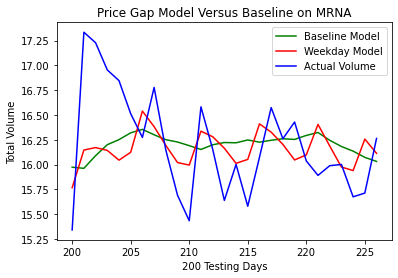

In [16]:
model_try_results1('MRNA',200,240)

In [5]:
#First Model – Residual Regression (See Paper)
#Input desired stock (ticker) as a str and starting/ending date preferences
#Outputs a graph of the model versus the baseline
def model_try_results1(ticker, n,m):
    stock = sp.loc[sp.symbol == ticker].reset_index(drop=True)
    one = DailyModel(stock)[0]
    two = stock.loc[stock.index > 710].log_vol
    M = stock.loc[stock.index > 710].M
    T = stock.loc[stock.index > 710].Tu
    W = stock.loc[stock.index > 710].W
    Th = stock.loc[stock.index > 710].Th
    F = stock.loc[stock.index > 710].F
    attempt = pd.concat([one, two,M,T,W,Th,F], axis=1).reset_index(drop=True)
    attempt['res'] = attempt.log_vol - attempt.log_total_vol_hat
    attempt
    result = smf.ols(formula = "res ~ M + Tu + W + Th + F",data = attempt).fit()
    # print(result.summary())
    attempt['Weekday_Model'] = attempt.log_total_vol_hat + result.params[0] + result.params[1] * attempt.M + result.params[3] * attempt.W + result.params[4] * attempt.Th + result.params[5] * attempt.F 
    plt.plot(attempt.log_total_vol_hat[n:m], color = 'g',label = 'Baseline Model')
    plt.plot(attempt.Weekday_Model[n:m], color = 'r',label = 'Weekday Model')
    plt.plot(attempt.log_vol[n:m], color = 'b',label = 'Actual Volume')
    plt.legend()
    plt.title("Price Gap Model Versus Baseline on " + ticker)
    plt.xlabel(str(n) + " Testing Days")
    plt.ylabel("Total Volume")
    print('New Model: ' + str((  np.sum(  abs(  attempt.Weekday_Model - attempt.log_vol  )  )  /296)) + ' ' \
          + 'Baseline: ' + str((  np.sum(  abs(  attempt.log_total_vol_hat - attempt.log_vol  )  )  )/296))

In [6]:
# First Model
#Input desired stock (ticker) as a str and starting/ending date preferences
#Outputs a residual plot of the model versus the baseline
def model_try_results2(ticker, n,m):
    stock = sp.loc[sp.symbol == ticker].reset_index(drop=True)
    one = DailyModel(stock)[0]
    two = stock.loc[stock.index > 710].log_vol
    M = stock.loc[stock.index > 710].M
    T = stock.loc[stock.index > 710].Tu
    W = stock.loc[stock.index > 710].W
    Th = stock.loc[stock.index > 710].Th
    F = stock.loc[stock.index > 710].F
    attempt = pd.concat([one, two,M,T,W,Th,F], axis=1).reset_index(drop=True)
    attempt['res'] = attempt.log_vol - attempt.log_total_vol_hat
    attempt
    result = smf.ols(formula = "res ~ M + Tu + W + Th + F",data = attempt).fit()
    # print(result.summary())
    attempt['Weekday_Model'] = attempt.log_total_vol_hat + result.params[0] + result.params[1] * attempt.M + result.params[3] * attempt.W + result.params[4] * attempt.Th + result.params[5] * attempt.F 
    attempt['Weekday_Residual'] = attempt.Weekday_Model - attempt.log_vol
    attempt['Baseline_Residual'] = attempt.log_total_vol_hat - attempt.log_vol
#     plt.plot(attempt.Baseline_Residual[n:m], color = 'g',label = 'Baseline Model')
#     plt.plot(attempt.Weekday_Residual[n:m], color = 'r',label = 'Weekday Model')
#     plt.legend()
#     plt.title("Price Gap Model Versus Baseline on " + ticker)
#     plt.xlabel(str(n) + " Testing Days")
#     plt.ylabel("Residual Volume")
#     print('New Model: ' + str((  np.sum(  abs(  attempt.Weekday_Model - attempt.log_vol  )  )  /296)) + ' ' \
#           + 'Baseline: ' + str((  np.sum(  abs(  attempt.log_total_vol_hat - attempt.log_vol  )  )  )/296))
    return [(np.sum(  abs(  attempt.Weekday_Model - attempt.log_vol  )  )  /296), \
          ( np.sum(  abs(  attempt.log_total_vol_hat - attempt.log_vol  )  )  )/296]

In [7]:
#Second Model – Multiplier Model (See Paper)
#Input desired stock (ticker) as a str and starting/ending date preferences
#Outputs a graph of the model versus the baseline
def model_two_try_results1(ticker, n,m):
    stock = sp.loc[sp.symbol == ticker].reset_index(drop=True)
    one = DailyModel(stock)[0]
    two = stock.loc[stock.index > 710].log_vol
    three = two/one
    M = stock.loc[stock.index > 710].M
    T = stock.loc[stock.index > 710].Tu
    W = stock.loc[stock.index > 710].W
    Th = stock.loc[stock.index > 710].Th
    F = stock.loc[stock.index > 710].F
    attempt = pd.concat([one, two, M,T,W,Th,F], axis=1).reset_index(drop=True)
    attempt['Quotient'] = 1 - attempt.log_vol / attempt.log_total_vol_hat
    result = smf.ols(formula = "Quotient ~ M + Tu + W + Th + F",data = attempt).fit()
    # print(result.summary())
    attempt['Weekday_Model'] = attempt.log_total_vol_hat +(result.params[0] + result.params[1] * attempt.M \
                                + result.params[3] * attempt.W + result.params[4] * attempt.Th \
                                + result.params[5] * attempt.F) * attempt.log_total_vol_hat
    plt.plot(attempt.log_total_vol_hat[n:m], color = 'g',label = 'Baseline Model')
    plt.plot(attempt.Weekday_Model[n:m], color = 'r',label = 'Weekday Model')
    plt.plot(attempt.log_vol[n:m], color = 'b',label = 'Actual Volume')
    plt.legend()
    plt.title("Weekday Model 2 Versus Baseline on " + ticker)
    plt.xlabel(str(n) + " Testing Days")
    plt.ylabel("Total Volume")
    print('New Model: ' + str((  np.sum(  abs(  attempt.Weekday_Model - attempt.log_vol  )  )  /296)) + ' ' \
          + 'Baseline: ' + str((  np.sum(  abs(  attempt.log_total_vol_hat - attempt.log_vol  )  )  )/296))

In [8]:
#Second Model – Multiplier Model (See Paper)
#Input desired stock (ticker) as a str and starting/ending date preferences
#Outputs a residual plot of the model versus the baseline
def model_two_try_results2(ticker, n,m):
    stock = sp.loc[sp.symbol == ticker].reset_index(drop=True)
    one = DailyModel(stock)[0]
    two = stock.loc[stock.index > 710].log_vol
    three = two/one
    M = stock.loc[stock.index > 710].M
    T = stock.loc[stock.index > 710].Tu
    W = stock.loc[stock.index > 710].W
    Th = stock.loc[stock.index > 710].Th
    F = stock.loc[stock.index > 710].F
    attempt = pd.concat([one, two, M,T,W,Th,F], axis=1).reset_index(drop=True)
    attempt['Quotient'] = 1 - attempt.log_vol / attempt.log_total_vol_hat
    result = smf.ols(formula = "Quotient ~ M + Tu + W + Th + F",data = attempt).fit()
    # print(result.summary())
    attempt['Weekday_Model'] = attempt.log_total_vol_hat +(result.params[0] + result.params[1] * attempt.M \
                                + result.params[3] * attempt.W + result.params[4] * attempt.Th \
                                + result.params[5] * attempt.F) * attempt.log_total_vol_hat
#     plt.plot(attempt.Baseline_Residual[n:m], color = 'g',label = 'Baseline Model')
#     plt.plot(attempt.Weekday_Residual[n:m], color = 'r',label = 'Weekday Model')
#     plt.legend()
#     plt.title("Price Gap Model Versus Baseline on " + ticker)
#     plt.xlabel(str(n) + " Testing Days")
#     plt.ylabel("Residual Volume")
#     print('New Model: ' + str((  np.sum(  abs(  attempt.Weekday_Model - attempt.log_vol  )  )  /296)) + ' ' \
#           + 'Baseline: ' + str((  np.sum(  abs(  attempt.log_total_vol_hat - attempt.log_vol  )  )  )/296))
    return [(np.sum(  abs(  attempt.Weekday_Model - attempt.log_vol  )  )  /296), \
          ( np.sum(  abs(  attempt.log_total_vol_hat - attempt.log_vol  )  )  )/296]

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packa

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning:

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykern

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

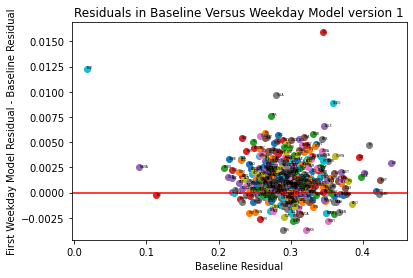

In [10]:
#Comparitive Scatterplot First Model
plt.xlabel('Baseline Residual')
plt.ylabel('First Weekday Model Residual - Baseline Residual')
plt.title("Residuals in Baseline Versus Weekday Model version 1")
tickers = sp.SYM_ROOT.unique()
for ticker in tickers:
    try:
        cur = model_try_results2(ticker,1,2)
        plt.scatter(cur[1],cur[1]-cur[0])
        plt.annotate(ticker,(cur[1],cur[1]-cur[0]),fontsize=3)
    except:
        pass
plt.axhline(y=0, color='r', linestyle='-')
plt.savefig('Model_1_Weekday', dpi=300)
plt.show()

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packa

/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: 

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning:

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykern

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

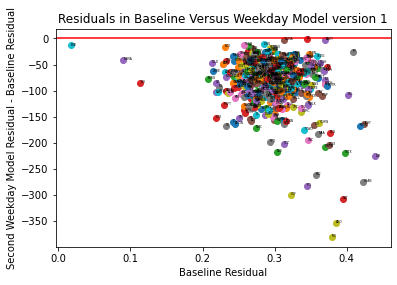

In [37]:
#Comparitive Scatterplot Second Model
plt.xlabel('Baseline Residual')
plt.ylabel('Second Weekday Model Residual - Baseline Residual')
plt.title("Residuals in Baseline Versus Weekday Model version 1")
tickers = sp.SYM_ROOT.unique()
for ticker in tickers:
    try:
        cur = model_two_try_results2(ticker,1,2)
        plt.scatter(cur[1],cur[1]-cur[0])
        plt.annotate(ticker,(cur[1],cur[1]-cur[0]),fontsize=3)
    except:
        pass
plt.axhline(y=0, color='r', linestyle='-')
plt.savefig('Model_2_Weekday', dpi=300)
plt.show()

In [42]:
# Model 3 – AR with Weekday Term Using Standard Optimization
#Input desired stock (ticker) as a str and starting/ending date preferences
#Outputs a residual plot of the model versus the baseline
def model_three_try_results2(ticker, n,m):
    stock = sp.loc[sp.symbol == ticker].reset_index(drop=True)
    one = DailyModel(stock)[0]
    two = stock.loc[stock.index > 710].log_vol
    M = stock.loc[stock.index > 710].M
    T = stock.loc[stock.index > 710].Tu
    W = stock.loc[stock.index > 710].W
    Th = stock.loc[stock.index > 710].Th
    F = stock.loc[stock.index > 710].F
    attempt = pd.concat([one, two, M,T,W,Th,F], axis=1).reset_index(drop=True)
    result = smf.ols(formula = "log_vol ~ M + Tu + W + Th + F + log_total_vol_hat",data = attempt).fit()
    print(result.summary())
    attempt['Weekday_Model'] =  result.params[0] + result.params[1] * attempt.M + result.params[2] * attempt.Tu\
                                + result.params[3] * attempt.W + result.params[4] * attempt.Th \
                                + result.params[5] * attempt.F * attempt.log_total_vol_hat \
                                + result.params[6] * attempt.log_total_vol_hat
    plt.plot(attempt.log_vol[n:m] - attempt.log_total_vol_hat[n:m], color = 'g',label = 'Baseline Residuals')
    plt.plot(attempt.log_vol[n:m] - attempt.Weekday_Model[n:m], color = 'r',label = 'Weekday Model')
    plt.legend()
    plt.title("Weekday Model 3 " + ticker)
    plt.xlabel(str(n) + " Testing Days")
    plt.ylabel("Residual Volume")
#     print('New Model: ' + str((  np.sum(  abs(  attempt.Weekday_Model - attempt.log_vol  )  )  /296)) + ' ' \
#           + 'Baseline: ' + str((  np.sum(  abs(  attempt.log_total_vol_hat - attempt.log_vol  )  )  )/296))
    return [(np.sum(  abs(  attempt.Weekday_Model - attempt.log_vol  )  )  /296), \
          ( np.sum(  abs(  attempt.log_total_vol_hat - attempt.log_vol  )  )  )/296]

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:70: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_28633/133783516.py:89: RuntimeWarning: overflow encountered in true_divide
  L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00

                            OLS Regression Results                            
Dep. Variable:                log_vol   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.149
Date:                Wed, 18 May 2022   Prob (F-statistic):            0.00118
Time:                        14:24:58   Log-Likelihood:                -45.279
No. Observations:                 297   AIC:                             102.6
Df Residuals:                     291   BIC:                             124.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.4159      1.74

[4.250517454037971, 0.22983436267931556]

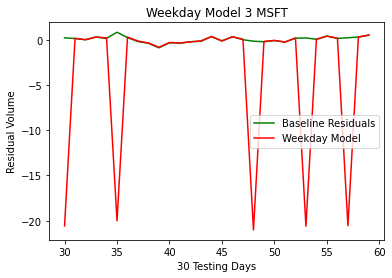

In [43]:
model_three_try_results2('MSFT',30,60)